In [1]:
using Revise

In [2]:
using LazySets
using ModelVerification

  ** incremental compilation may be fatally broken for this module **



  ** incremental compilation may be fatally broken for this module **



In [3]:
using PyCall
using CSV
using ONNX
using Flux
using DataFrames
using ONNXNaiveNASflux 

In [4]:
include("vnnlib_parser.jl")

read_vnnlib_simple (generic function with 1 method)

In [5]:

function onnx_to_nnet(onnx_file)
    pushfirst!(PyVector(pyimport("sys")."path"), dirname(dirname(@__FILE__)))
    nnet = pyimport("NNet")
    use_gz = split(onnx_file, ".")[end] == "gz"
    if use_gz
        onnx_file = onnx_file[1:end-3]
    end
    nnet_file = onnx_file[1:end-4] * "nnet"
    isfile(nnet_file) && return
    nnet.onnx2nnet(onnx_file, nnetFile=nnet_file)
end

function verify_an_instance(onnx_file, spec_file, timeout)
    use_gz = split(onnx_file, ".")[end] == "gz"
    nnet_file = use_gz ? onnx_file[1:end-7] * "nnet" : onnx_file[1:end-4] * "nnet"
    net = ModelVerification.read_nnet(nnet_file)
    ###### TODO: change this ad-hoc remedy for nnet read ######
    net.layers[1] = ModelVerification.Layer(net.layers[1].weights, net.layers[1].bias, ModelVerification.Id())
    flux_model = Flux.Chain(net)
    new_onnx_file = "/home/verification/ModelVerification.jl/tmp/" * onnx_file[end-31:end]
    #ONNXNaiveNASflux.save(new_onnx_file, flux_model, (5,5))
    n_in = size(net.layers[1].weights)[2]
    n_out = length(net.layers[end].bias)
    specs = read_vnnlib_simple(spec_file, n_in, n_out)
    #current_time = 0
    for spec in specs
        X_range, Y_cons = spec
        lb = [bd[1] for bd in X_range]
        ub = [bd[2] for bd in X_range]
        X = Hyperrectangle(low = lb, high = ub)
        res = nothing
        A = []
        b = []
        # println("fuck")
        # println(Y_cons)
        for Y_con in Y_cons
            A = hcat(Y_con[1]...)'
            b = Y_con[2]
            Yc = HPolytope(A, b)
            Y = Complement(Yc)
            search_method = BFS(max_iter=1, batch_size=512)
            split_method = Bisect(1)
            prop_method = AlphaCrown(Crown(true, true), true, false, Flux.Optimiser(Flux.ADAM(0.1)), 10)#Crown(true, true)
            problem = Problem(new_onnx_file, X, Y)
            res = @timed verify(search_method, split_method, prop_method, problem)
            #current_time += res.time 
            #println(current_time)
            #if(current_time >= timeout)
                #println("timed out at:", current_time)
                #return "unknown"
            #end
            res.value.status == :violated && (return "violated")
            res.value.status == :unknown && (return "unknown")
        end
    end
    return "holds"
end

function run_all(instance_csv, result_csv)
    file = CSV.File(instance_csv, header=false)
    dirpath = dirname(instance_csv)
    df = DataFrame()
    for (index,row) in enumerate(file)
        println("Instance $index.")
        onnx_file = joinpath(dirpath, row[1])
        vnnlib_file = joinpath(dirpath, row[2])
        timeout = row[3]
        onnx_to_nnet(onnx_file)
        result = @timed verify_an_instance(onnx_file, vnnlib_file, timeout)
        println(result)
        push!(df, result)
    end
    CSV.write(result_csv, df)
end

run_all (generic function with 1 method)

In [6]:
# # expected holds
# onnx_file = "../../vnncomp2021/benchmarks/acasxu/ACASXU_run2a_4_5_batch_2000.onnx"
# spec_file = "../../vnncomp2021/benchmarks/acasxu/prop_10.vnnlib"
# expected violated
onnx_file = "/home/verification/vnncomp2021/benchmarks/acasxu/ACASXU_run2a_1_2_batch_2000.onnx"
spec_file = "/home/verification/vnncomp2021/benchmarks/acasxu/prop_2.vnnlib"
timeout = 116
verify_an_instance(onnx_file, spec_file, timeout)

batch_bound.batch_data_min max


(5, 1)(5, 1)


"unknown"

In [43]:
run_all("/home/verification/vnncomp2021/benchmarks/acasxu/acasxu_instances.csv", "./alphacrown_result.csv")

Instance 1.
(value = "holds", time = 22.276801255, bytes = 1876530763, gctime = 0.954916517, gcstats = Base.GC_Diff(1876530763, 1151, 0, 42253501, 1601, 1133, 954916517, 5, 0))
Instance 2.
(value = "holds", time = 65.30261418, bytes = 6946068521, gctime = 3.382196998, gcstats = Base.GC_Diff(6946068521, 2382, 0, 157794284, 19082, 2477, 3382196998, 19, 0))
Instance 3.
(value = "unknown", time = 101.851254715, bytes = 12779430144, gctime = 5.633012461, gcstats = Base.GC_Diff(12779430144, 9664, 0, 280733988, 40985, 9470, 5633012461, 34, 0))
Instance 4.
(value = "unknown", time = 99.878295666, bytes = 12606088541, gctime = 5.585151488, gcstats = Base.GC_Diff(12606088541, 8673, 0, 279393736, 40730, 8633, 5585151488, 33, 0))
Instance 5.
(value = "holds", time = 34.966638483, bytes = 3215227392, gctime = 1.538614517, gcstats = Base.GC_Diff(3215227392, 1443, 0, 72965078, 3985, 1421, 1538614517, 8, 0))
Instance 6.
(value = "holds", time = 20.887110157, bytes = 1853230458, gctime = 0.947095856, g

18.714216821, bytes = 2083260650, gctime = 0.782439049, gcstats = Base.GC_Diff(2083260650, 1159, 0, 46449948, 5948, 1053, 782439049, 4, 0))
Instance 57.
(value = "violated", time = 0.800782605, bytes = 42830041, gctime = 0.220968056, gcstats = Base.GC_Diff(42830041, 47, 0, 989330, 350, 224, 220968056, 1, 0))
Instance 58.
(value = "unknown", time = 103.596033153, bytes = 13238019848, gctime = 5.534006761, gcstats = Base.GC_Diff(13238019848, 11094, 0, 281399071, 40824, 10707, 5534006761, 29, 0))
Instance 59.
(value = "violated", time = 0.446076497, bytes = 24107082, gctime = 0.0, gcstats = Base.GC_Diff(24107082, 47, 0, 404332, 348, 0, 0, 0, 0))
Instance 60.
(value = "violated", time = 0.429255568, bytes = 24108009, gctime = 0.0, gcstats = Base.GC_Diff(24108009, 47, 0, 404331, 348, 0, 0, 0, 0))
Instance 61.
(value = "violated", time = 0.812729924, bytes = 39327104, gctime = 0.205632234, gcstats = Base.GC_Diff(39327104, 47, 0, 879948, 348, 538, 205632234, 1, 0))
Instance 62.
(value = "viol


(value = "unknown", time = 111.772527679, bytes = 12900900597, gctime = 5.838317009, gcstats = Base.GC_Diff(12900900597, 9498, 0, 281873196, 40993, 9189, 5838317009, 27, 0))
Instance 117.
(value = "unknown", time = 114.51741687, bytes = 13474616815, gctime = 6.019027104, gcstats = Base.GC_Diff(13474616815, 11011, 0, 289177995, 41906, 10937, 6019027104, 29, 0))
Instance 118.
(value = "unknown", time = 106.445926359, bytes = 12869385569, gctime = 6.033439368, gcstats = Base.GC_Diff(12869385569, 9494, 0, 281818788, 40987, 9596, 6033439368, 27, 0))
Instance 119.
(value = "unknown", time = 103.639003312, bytes = 13195731968, gctime = 5.990057134, gcstats = Base.GC_Diff(13195731968, 11062, 0, 282254655, 40958, 10930, 5990057134, 28, 0))
Instance 120.
(value = "unknown", time = 104.614965619, bytes = 12790940043, gctime = 6.054875077, gcstats = Base.GC_Diff(12790940043, 8791, 0, 282022384, 41019, 9026, 6054875077, 27, 0))
Instance 121.
(value = "holds", time = 8.603919155, bytes = 695276900,

(12753535423, 10274, 0, 278277307, 40015, 9862, 5545878910, 25, 0))
Instance 173.
(value = "holds", time = 13.197452324, bytes = 1128617276, gctime = 0.542685425, gcstats = Base.GC_Diff(1128617276, 937, 0, 25091136, 1487, 1129, 542685425, 2, 0))
Instance 174.
(value = "holds", time = 22.263524712, bytes = 2347775307, gctime = 1.200452771, gcstats = Base.GC_Diff(2347775307, 1275, 0, 53055936, 2864, 1469, 1200452771, 5, 0))
Instance 175.
(value = "holds", time = 11.42790715, bytes = 898577338, gctime = 0.523573384, gcstats = Base.GC_Diff(898577338, 713, 0, 19782957, 1367, 758, 523573384, 2, 0))
Instance 176.
(value = "holds", time = 38.937116982, bytes = 3564604835, gctime = 1.974277187, gcstats = Base.GC_Diff(3564604835, 1599, 0, 80491079, 5903, 1604, 1974277187, 7, 0))
Instance 177.
(value = "unknown", time = 105.766212654, bytes = 12589419408, gctime = 5.981795882, gcstats = Base.GC_Diff(12589419408, 7408, 0, 281754157, 41382, 7343, 5981795882, 25, 0))
Instance 178.
(value = "holds", 

"./alphacrown_result.csv"

In [37]:
time1 = @elapsed begin
    # 执行一些耗时的操作
    sleep(2)  # 模拟一个耗时的操作，程序将休眠2秒
end
time2 = @elapsed begin
    # 执行一些耗时的操作
    sleep(5)  # 模拟一个耗时的操作，程序将休眠2秒
end
println("代码已经运行了 $elapsed_time 秒")
println(time2+time1)

代码已经运行了 8.001899456 秒
7.002479682000001


In [57]:
using Plots

In [48]:
cr_df = DataFrame(CSV.File("/home/verification/ModelVerification.jl/tmp/alphacrown_result.csv", header=true))
cr_df[mv_df.time .> 116, :time] .= 116
t = histogram(cr_df.time, bins=100, label="Crown")
xlabel!("time (s)")
ylabel!("count")
display(t)

UndefVarError: UndefVarError: mv_df not defined

In [54]:
mv_df = DataFrame(CSV.File("./result.csv", header=true))
mv_df[mv_df.time .> 116, :time] .= 116
t = histogram(mv_df.time, bins=100, label="ModelVerification")
xlabel!("time (s)")
ylabel!("count")
display(t)

UndefVarError: UndefVarError: histogram not defined

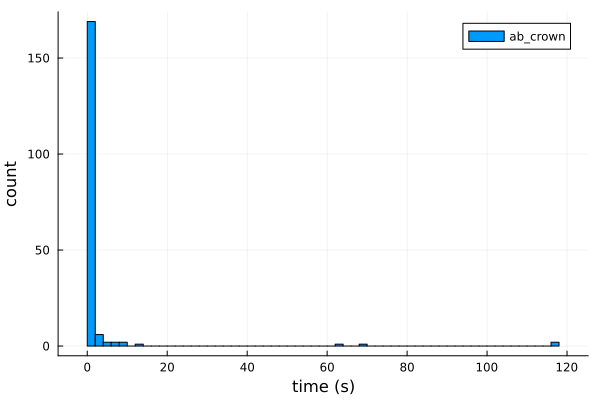

In [11]:
ab_df = DataFrame(CSV.File("./abcrown_result.csv", header=true))
ab_df[!,:value] = convert.(String15, ab_df[!,:value])
ab_df[ab_df.value .== "safe", :value] .= "holds"
ab_df[ab_df.value .== "unsafe", :value] .= "violated"
t = histogram(ab_df.time, bins=100, label="ab_crown")
xlabel!("time (s)")
ylabel!("count")
display(t)

In [52]:
println(sum(cr_df.value .== "holds"))
println(sum(cr_df.value .== "violated"))
println(sum(cr_df.value .== "unknown"))

55
35
96


In [56]:
ab_df = DataFrame(CSV.File("/home/verification/ModelVerification.jl/tmp/result.csv", header=true))
println(sum(ab_df.value .== "holds"))
println(sum(ab_df.value .== "violated"))
println(sum(ab_df.value .== "unknown"))

129
45
12


In [55]:
mv_df = DataFrame(CSV.File("/home/verification/ModelVerification.jl/tmp/crown_result.csv", header=true))
println(sum(mv_df.value .== "holds"))
println(sum(mv_df.value .== "violated"))
println(sum(mv_df.value .== "unknown"))

96
43
47


In [15]:
[mv_df[mv_df.value .!= ab_df.value, :value], ab_df[mv_df.value .!= ab_df.value, :value]]

2-element Vector{AbstractVector{String15}}:
 ["unknown", "unknown", "unknown", "unknown", "violated", "unknown", "unknown", "unknown", "unknown", "unknown", "unknown", "unknown"]
 ["holds", "holds", "holds", "holds", "unknown", "holds", "holds", "holds", "holds", "holds", "violated", "holds"]